In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import gc
import os
import numpy as np
import shutil
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Setting CUDA devices as visible
cuda_devices = "0,1"
# os.environ["CUDA_VISIBLE_DEVICES"] = cuda_devices

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("Using GPUs:")
    for device_id in cuda_devices.split(','):
        device = torch.device(f"cuda:{device_id}")
        print(f"  Device {device_id}: {torch.cuda.get_device_name(int(device_id))}")
else:
    print("Using CPU")

Using GPUs:
  Device 0: NVIDIA GeForce RTX 3090
  Device 1: NVIDIA GeForce RTX 3090


In [4]:
torch.cuda.empty_cache()
gc.collect()


11

In [5]:
def get_classes(directory):
    class_list = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path) and os.listdir(item_path):
            class_list.append(item)
    return class_list

In [6]:
in_dir = "/mnt/nis_lab_research/data/class_data/neg/far_shah_b1-b5_b8_train_neg_cln"
out_dir = "../../data/classifier/far_shah_b1-b5_b8_train_neg_cln"
num_workers = os.cpu_count() or 32
epochs = 25
class_list = sorted(get_classes(in_dir))
num_classes = len(class_list)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
    transforms.ToTensor(),
    # CHANGE TO BE DATA SPECIFIC
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [8]:
def tt_split(input_dir, out_dir, train_ratio):
    """
    Splits the dataset in the given directory into train and test sets.

    :param input_dir: Path to the input directory.
    :param train_ratio: Ratio of train set (between 0 and 1).
    """
    if not 0 <= train_ratio <= 1:
        raise ValueError("Train ratio must be between 0 and 1")

    base_dir = out_dir
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create train and test directories
    for directory in [train_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    # Process each class directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if os.path.isdir(class_dir):
            # Create class directories in train and test
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Get a list of images and shuffle them
            images = os.listdir(class_dir)
            random.shuffle(images)

            # Split images into train and test
            split_point = int(len(images) * train_ratio)
            train_images = images[:split_point]
            test_images = images[split_point:]

            # Copy images to train and test directories
            for image in train_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(train_dir, class_name))
            for image in test_images:
                shutil.copy2(os.path.join(class_dir, image), os.path.join(test_dir, class_name))

In [9]:
tt_split(in_dir, out_dir, 0.8)

In [11]:
train_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=num_workers)


In [12]:
test_set = torchvision.datasets.ImageFolder(root='../../data/classifier/' + in_dir.split("/")[-1] + '/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=num_workers)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 27 total classes - text captcha have 0 so it is removed for now
model = model.to(device)
model = nn.DataParallel(model)  # Use DataParallel

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 4. You can do so by setting
    the device_ids argument to DataP

In [14]:
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for i, data in progress_bar:
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the primary device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (i + 1))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
print('Finished Training')

Epoch 1/25:   0%|          | 0/847 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pyt_user/miniconda3/envs/pyt_venv/lib/python3.11/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encount

RuntimeError: DataLoader worker (pid(s) 10941) exited unexpectedly

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Une

In [ ]:
# Can be saved directly from the GPU
torch.save(model, './pth/test_ep25.pth')

In [ ]:
# # To load the model later
# model = torch.load('./pth/far_shah_b1-b3_rn50_ep25.pth')
# model.eval()  # Set it to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.eval()  # Set the model to evaluation mode

# Variables to hold predictions and actual labels
y_pred = []
y_true = []
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Assuming outputs are raw scores from your model
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate true labels and predictions
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probabilities.cpu().numpy())
        

In [ ]:
len(set(y_true))

27

In [ ]:
gt_by_class = []
for i in range (0, num_classes):
    tmp = []
    for j, gt in enumerate(y_true):
        if i == gt:
            tmp.append([gt, y_pred[j]])
        
    gt_by_class.append(tmp)
     

In [ ]:
tot = 0 
for i, class_ in enumerate(gt_by_class):
    class_cntr = 1
    for inst in class_:
        if inst[0] == inst[1]:
            class_cntr += 1
    print(i, class_list[i], class_cntr)
    tot = tot + class_cntr / len(class_)

0 Accept Button 529
1 Advertisement 415
2 Alert Notification 1144
3 Allow Button 73
4 Checkbox 240
5 Click Captcha 36
6 Close Button 823
7 Download Button 195
8 Email Input Box 180
9 General Button 34485
10 General Input Box 208
11 Image Captcha 2
12 Login Button 1251
13 Logo 4527
14 Name Input Box 128
15 Password Input Box 90
16 Phone Input Box 27
17 Play Button 286
18 Popup 279
19 Random 49793
20 Search Button 1419
21 Search Input Box 784
22 Submit Button 62
23 Text Captcha 3
24 Toggle Button 86
25 Update Button 7
26 Video 295


In [ ]:
tot/len(gt_by_class)

0.9365854779177932

OVERALL METRICS
Accuracy: 96.67%
Precision: 0.9669
Recall: 0.9667
F1 Score: 0.9665

ACCURACY BY CLASS
Accept Button (class 0): 90.26%
Advertisement (class 1): 93.88%
Alert Notification (class 2): 96.21%
Allow Button (class 3): 94.74%
Checkbox (class 4): 91.57%
Click Captcha (class 5): 100.00%
Close Button (class 6): 91.54%
Download Button (class 7): 91.08%
Email Input Box (class 8): 82.49%
General Button (class 9): 95.40%
General Input Box (class 10): 80.54%
Image Captcha (class 11): 50.00%
Login Button (class 12): 92.18%
Logo (class 13): 93.26%
Name Input Box (class 14): 74.27%
Password Input Box (class 15): 84.76%
Phone Input Box (class 16): 70.27%
Play Button (class 17): 91.05%
Popup (class 18): 95.53%
Random (class 19): 98.95%
Search Button (class 20): 89.63%
Search Input Box (class 21): 91.05%
Submit Button (class 22): 88.41%
Text Captcha (class 23): 100.00%
Toggle Button (class 24): 94.44%
Update Button (class 25): 85.71%
Video (class 26): 92.74%


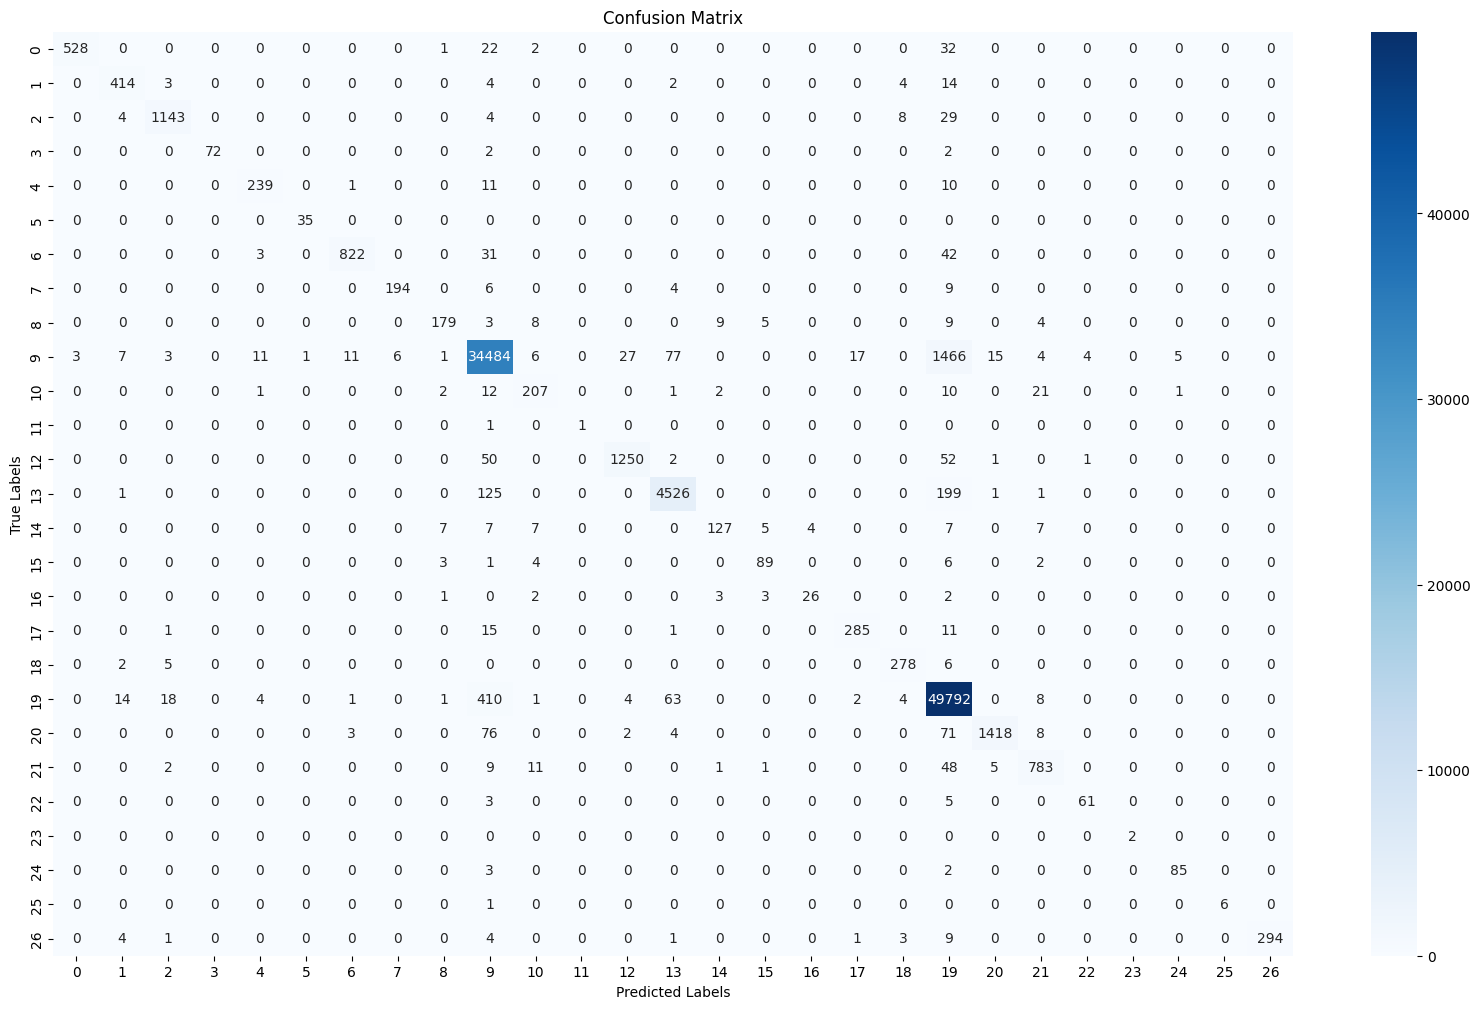

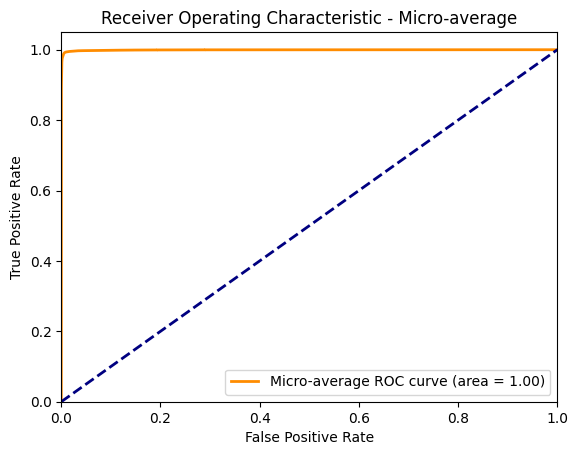

In [ ]:

# Convert accumulated predictions and labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_score = np.array(y_score)

# Determine the unique classes in y_true and binarize
classes = np.unique(y_true)  # Identify unique class labels
y_true_binarized = label_binarize(y_true, classes=classes)

n_classes = len(classes)

# Calculate metrics
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average="weighted", labels=classes)
recall = recall_score(y_true, y_pred, average="weighted", labels=classes)
f1 = f1_score(y_true, y_pred, average="weighted", labels=classes)

# ROC Curve and AUC for Micro-average
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Print metrics
print("OVERALL METRICS")
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate accuracy by class
accuracies_by_class = {}
for cls in classes:
    idx = np.where(y_true == cls)[0]
    accuracy_cls = accuracy_score(y_true[idx], y_pred[idx])
    accuracies_by_class[cls] = accuracy_cls

# Print accuracy by class
print()
print("ACCURACY BY CLASS")
for cls, acc in accuracies_by_class.items():
    print(f'{class_list[cls]} (class {cls}): {acc * 100:.2f}%')

# Calculate and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot ROC Curve for Micro-average
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Micro-average')
plt.legend(loc='lower right')
plt.show()